#📌 Extracão

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. CONFIGURAÇÃO INICIAL ---
# Ajustes para melhor visualização no terminal
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

# Estilo dos gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("🚀 INICIANDO PIPELINE DE DADOS COMPLETO (TELECOM X)...\n")

# =============================================================================
# ETAPA 1: EXTRAÇÃO (EXTRACTION)
# =============================================================================
url_api = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json"
print(f"🔄 [1/7] Baixando dados de: {url_api}...")

try:
    df_raw = pd.read_json(url_api)
    print("   ✅ Download concluído.")
except Exception as e:
    print(f"   ❌ Erro crítico no download: {e}")
    exit()

🚀 INICIANDO PIPELINE DE DADOS COMPLETO (TELECOM X)...

🔄 [1/7] Baixando dados de: https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json...
   ✅ Download concluído.


#🔧 Transformação

In [3]:
print("\n🛠️  [2/7] Normalizando dados aninhados (JSON)...")

# Expandindo os dicionários internos
df_customer = pd.json_normalize(df_raw['customer'].tolist())
df_phone    = pd.json_normalize(df_raw['phone'].tolist())
df_internet = pd.json_normalize(df_raw['internet'].tolist())
df_account  = pd.json_normalize(df_raw['account'].tolist())

# Concatenando
df_final = pd.concat([df_raw[['customerID', 'Churn']], df_customer, df_phone, df_internet, df_account], axis=1)
print(f"   📊 Dimensões após normalização: {df_final.shape}")

# =============================================================================
# ETAPA 3: LIMPEZA DE DADOS (CLEANING)
# =============================================================================
print("\n🧹 [3/7] Limpando inconsistências...")

# 3.1. Remover Churn vazio
df_final = df_final[df_final['Churn'] != '']

# 3.2. Converter 'Charges.Total' para número (tratando espaços como NaN)
df_final['Charges.Total'] = pd.to_numeric(df_final['Charges.Total'], errors='coerce')
df_final['Charges.Total'] = df_final['Charges.Total'].fillna(0)

# 3.3. Remover espaços em branco de todas as colunas de texto
colunas_texto = df_final.select_dtypes(include=['object']).columns
for col in colunas_texto:
    df_final[col] = df_final[col].str.strip()

print("   ✅ Limpeza concluída.")

# =============================================================================
# ETAPA 4: ENGENHARIA DE ATRIBUTOS - PARTE 1
# =============================================================================
print("\n⚗️  [4/7] Criando variáveis derivadas...")

# Criando Custo Diário
df_final['Contas_Diarias'] = df_final['Charges.Monthly'] / 30

# =============================================================================
# ETAPA 5: PADRONIZAÇÃO E TRADUÇÃO
# =============================================================================
print("\n🌍 [5/7] Traduzindo e Padronizando...")

# 5.1. Renomeando Colunas
mapa_colunas = {
    'customerID': 'ID_Cliente',
    'Churn': 'Evasao',
    'gender': 'Genero',
    'SeniorCitizen': 'Idoso',
    'Partner': 'Parceiro',
    'Dependents': 'Dependentes',
    'tenure': 'Meses_Contrato',
    'PhoneService': 'Servico_Telefonico',
    'MultipleLines': 'Multiplas_Linhas',
    'InternetService': 'Servico_Internet',
    'OnlineSecurity': 'Seguranca_Online',
    'OnlineBackup': 'Backup_Online',
    'DeviceProtection': 'Protecao_Dispositivo',
    'TechSupport': 'Suporte_Tecnico',
    'StreamingTV': 'Streaming_TV',
    'StreamingMovies': 'Streaming_Filmes',
    'Contract': 'Contrato',
    'PaperlessBilling': 'Fatura_Digital',
    'PaymentMethod': 'Metodo_Pagamento',
    'Charges.Monthly': 'Cobranca_Mensal',
    'Charges.Total': 'Cobranca_Total',
    'Contas_Diarias': 'Custo_Diario'
}
df_final.rename(columns=mapa_colunas, inplace=True)

# 5.2. Traduzindo Valores
df_final['Genero'] = df_final['Genero'].map({'Female': 'Feminino', 'Male': 'Masculino'})
df_final['Contrato'] = df_final['Contrato'].replace({
    'Month-to-month': 'Mensal', 'One year': '1 Ano', 'Two year': '2 Anos'
})
df_final['Metodo_Pagamento'] = df_final['Metodo_Pagamento'].replace({
    'Electronic check': 'Cheque Eletrônico', 'Mailed check': 'Cheque Enviado',
    'Bank transfer (automatic)': 'Transferência Bancária', 'Credit card (automatic)': 'Cartão de Crédito'
})
df_final['Servico_Internet'] = df_final['Servico_Internet'].replace('Fiber optic', 'Fibra Óptica')
df_final['Idoso'] = df_final['Idoso'].map({0: 0, 1: 1}) # Mantendo 0/1 mas garantindo int

# 5.3. Codificação Binária (Yes/No -> 1/0)
colunas_binarias = ['Evasao', 'Parceiro', 'Dependentes', 'Servico_Telefonico', 'Fatura_Digital',
                    'Seguranca_Online', 'Backup_Online', 'Protecao_Dispositivo',
                    'Suporte_Tecnico', 'Streaming_TV', 'Streaming_Filmes']

mapa_binario = {'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0}

for col in colunas_binarias:
    df_final[col] = df_final[col].replace(mapa_binario).astype(int)

# =============================================================================
# ETAPA 6: ENGENHARIA DE ATRIBUTOS - PARTE 2 (Pós-Codificação)
# =============================================================================
# Agora que os serviços são 0 e 1, podemos somá-los facilmente
cols_servicos = [
    'Seguranca_Online', 'Backup_Online', 'Protecao_Dispositivo',
    'Suporte_Tecnico', 'Streaming_TV', 'Streaming_Filmes'
]
df_final['Qtd_Servicos'] = df_final[cols_servicos].sum(axis=1)
print("   ✅ Variáveis criadas e traduzidas.")



🛠️  [2/7] Normalizando dados aninhados (JSON)...
   📊 Dimensões após normalização: (7267, 21)

🧹 [3/7] Limpando inconsistências...
   ✅ Limpeza concluída.

⚗️  [4/7] Criando variáveis derivadas...

🌍 [5/7] Traduzindo e Padronizando...
   ✅ Variáveis criadas e traduzidas.


/tmp/ipython-input-2640785439.py:92: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final[col] = df_final[col].replace(mapa_binario).astype(int)
/tmp/ipython-input-2640785439.py:92: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final[col] = df_final[col].replace(mapa_binario).astype(int)
/tmp/ipython-input-2640785439.py:92: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the futu

#📊 Carga e análise


📊 [7/7] Gerando Gráficos e Relatórios (Visualização Amigável)...


/tmp/ipython-input-3710083606.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_final, x='Evasao', palette=['#4c72b0', '#c44e52'], ax=ax[0])
/tmp/ipython-input-3710083606.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(['Não', 'Sim']) # <--- AQUI A MUDANÇA


   📸 Salvo: 1_distribuicao_evasao.png
   📸 Salvo: 2_analise_categorias.png


/tmp/ipython-input-3710083606.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final, x='Evasao', y=col, palette=['#4c72b0', '#c44e52'], ax=axes[i])
/tmp/ipython-input-3710083606.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Não', 'Sim']) # <--- AQUI A MUDANÇA
/tmp/ipython-input-3710083606.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final, x='Evasao', y=col, palette=['#4c72b0', '#c44e52'], ax=axes[i])
/tmp/ipython-input-3710083606.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usin

   📸 Salvo: 3_analise_numerica_boxplots.png
   📸 Salvo: 5_ranking_fatores.png


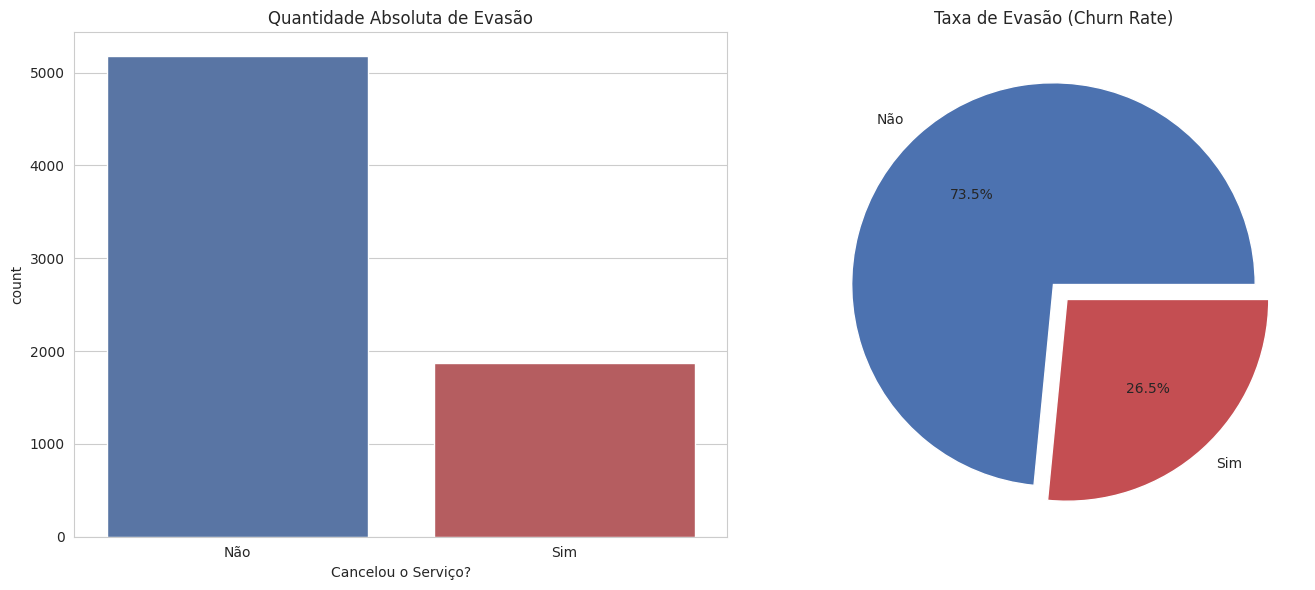

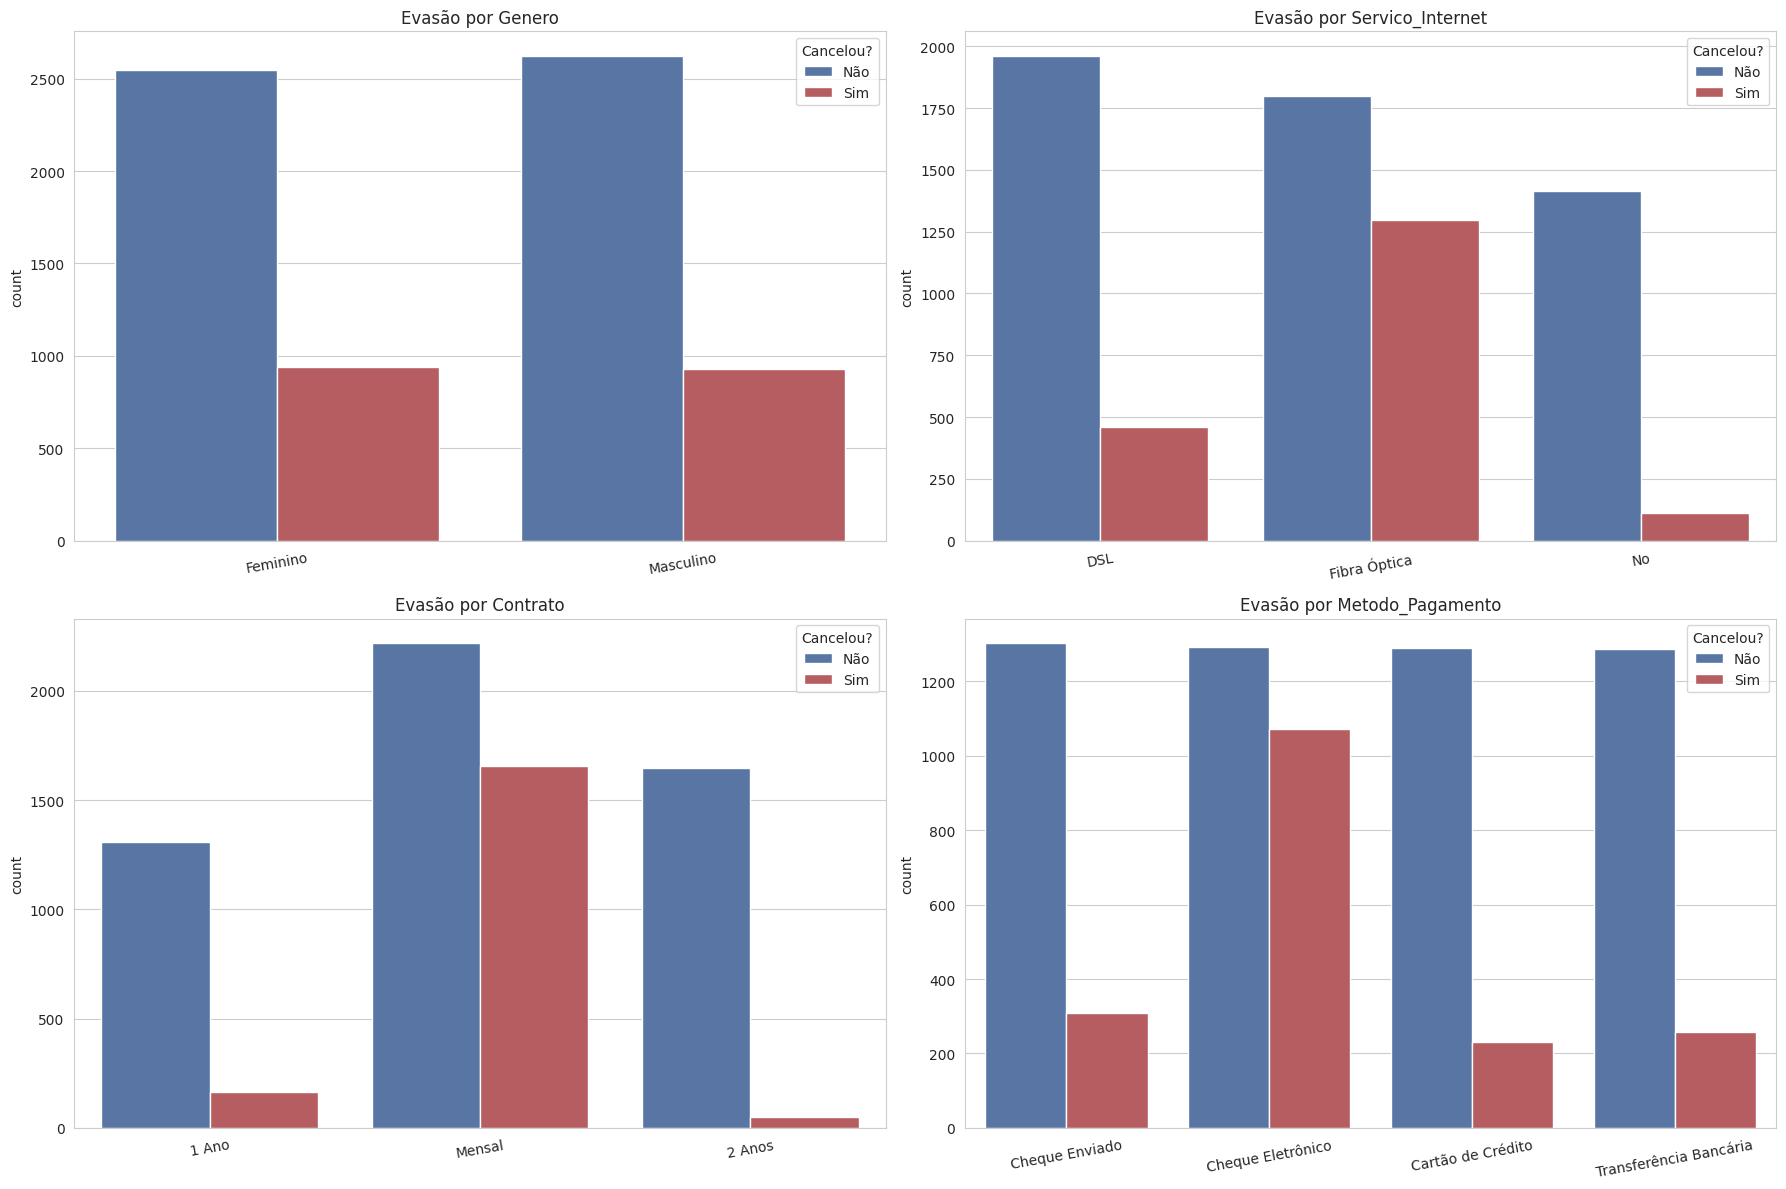

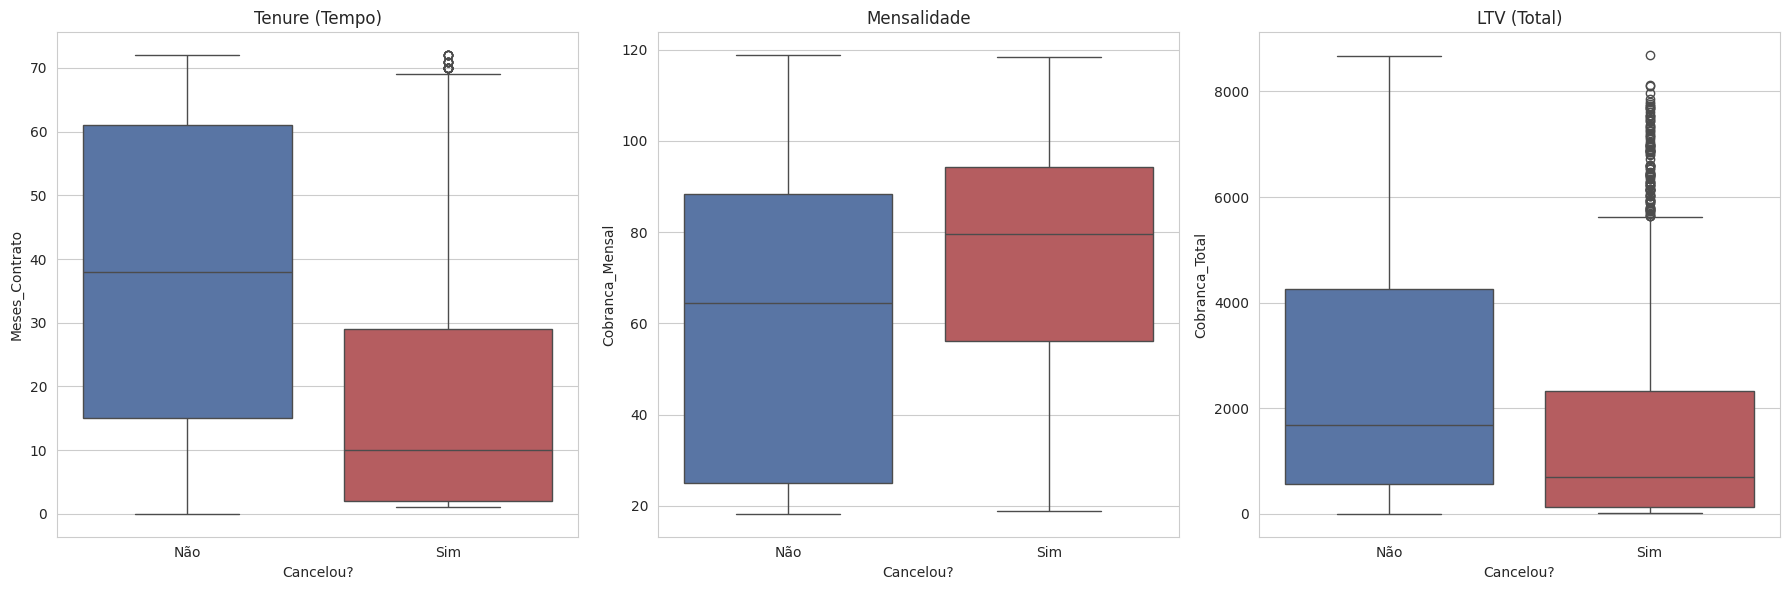

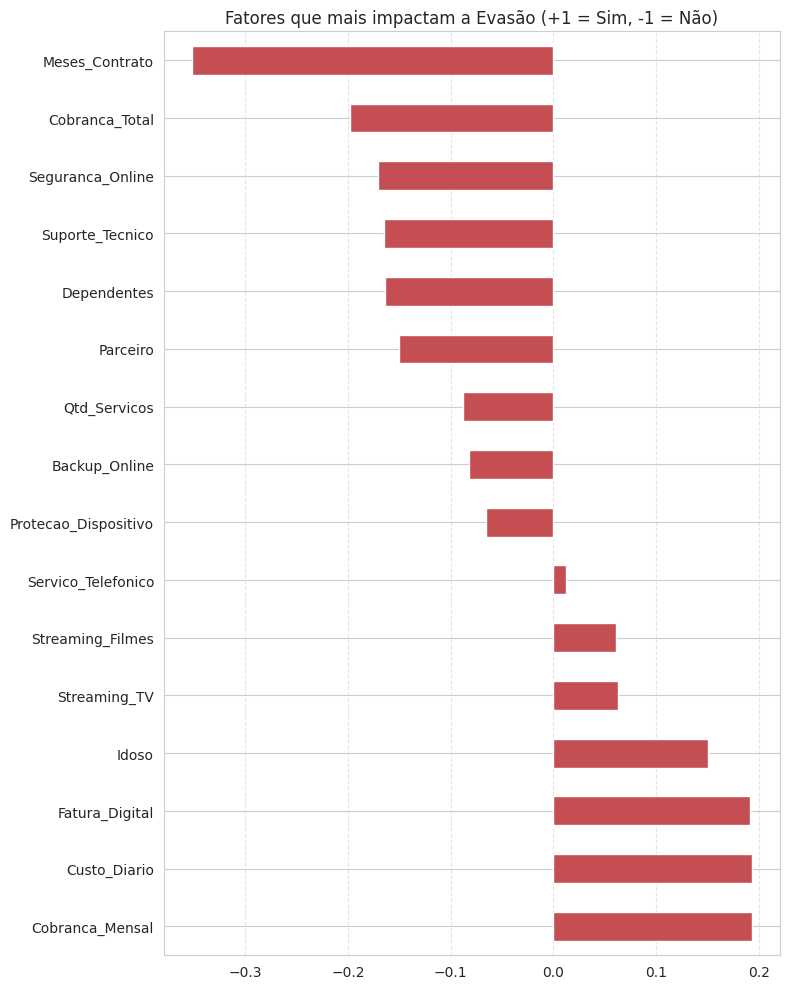

In [4]:
print("\n📊 [7/7] Gerando Gráficos e Relatórios (Visualização Amigável)...")

# --- A. Distribuição de Churn (Pizza e Barras) ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Barras
sns.countplot(data=df_final, x='Evasao', palette=['#4c72b0', '#c44e52'], ax=ax[0])
ax[0].set_title('Quantidade Absoluta de Evasão')
ax[0].set_xlabel('Cancelou o Serviço?')
ax[0].set_xticklabels(['Não', 'Sim']) # <--- AQUI A MUDANÇA

# Gráfico 2: Pizza
df_final['Evasao'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['#4c72b0', '#c44e52'],
    labels=['Não', 'Sim'], # <--- AQUI A MUDANÇA
    ax=ax[1],
    explode=(0, 0.1)
)
ax[1].set_title('Taxa de Evasão (Churn Rate)')
ax[1].set_ylabel('')

plt.tight_layout()
plt.savefig('1_distribuicao_evasao.png')
print("   📸 Salvo: 1_distribuicao_evasao.png")


# --- B. Análise Categórica (Grid 2x2) ---
cols_cat = ['Genero', 'Servico_Internet', 'Contrato', 'Metodo_Pagamento']
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, col in enumerate(cols_cat):
    ax_atual = axes[i//2, i%2]
    sns.countplot(data=df_final, x=col, hue='Evasao', palette=['#4c72b0', '#c44e52'], ax=ax_atual)

    ax_atual.set_title(f'Evasão por {col}')
    ax_atual.set_xlabel('')
    ax_atual.tick_params(axis='x', rotation=10)

    # Ajustando a legenda para Sim/Não
    ax_atual.legend(title='Cancelou?', labels=['Não', 'Sim']) # <--- AQUI A MUDANÇA

plt.tight_layout()
plt.savefig('2_analise_categorias.png')
print("   📸 Salvo: 2_analise_categorias.png")


# --- C. Análise Numérica (Boxplots) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
vars_num = ['Meses_Contrato', 'Cobranca_Mensal', 'Cobranca_Total']
titulos = ['Tenure (Tempo)', 'Mensalidade', 'LTV (Total)']

for i, col in enumerate(vars_num):
    sns.boxplot(data=df_final, x='Evasao', y=col, palette=['#4c72b0', '#c44e52'], ax=axes[i])
    axes[i].set_title(titulos[i])
    axes[i].set_xlabel('Cancelou?')
    axes[i].set_xticklabels(['Não', 'Sim']) # <--- AQUI A MUDANÇA

plt.tight_layout()
plt.savefig('3_analise_numerica_boxplots.png')
print("   📸 Salvo: 3_analise_numerica_boxplots.png")


# --- D. Ranking de Correlação (Este continua numérico pois é matemático) ---
plt.figure(figsize=(8, 10))
# Seleciona apenas numéricos
cols_corr = df_final.select_dtypes(include=['number']).columns
corr = df_final[cols_corr].corr()

corr['Evasao'].drop('Evasao').sort_values(ascending=False).plot(kind='barh', color='#c44e52')
plt.title('Fatores que mais impactam a Evasão (+1 = Sim, -1 = Não)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('5_ranking_fatores.png')
print("   📸 Salvo: 5_ranking_fatores.png")

#📄Relatorio Final

In [5]:
print("\n" + "="*50)
print("✅ RELATÓRIO FINAL GERADO COM SUCESSO")
print("="*50)
print(f"👥 Total de Clientes Analisados: {df_final.shape[0]}")
print(f"📉 Taxa Global de Evasão: {(df_final['Evasao'].mean() * 100):.2f}%")
print(f"💰 Ticket Médio Mensal: R$ {df_final['Cobranca_Mensal'].mean():.2f}")
print("-" * 50)
print("Arquivos de imagem gerados na pasta do projeto:")
print("1. 1_distribuicao_evasao.png")
print("2. 2_analise_categorias.png")
print("3. 3_analise_numerica_boxplots.png")
print("4. 4_matriz_correlacao.png")
print("5. 5_ranking_fatores.png")
print("="*50)


✅ RELATÓRIO FINAL GERADO COM SUCESSO
👥 Total de Clientes Analisados: 7043
📉 Taxa Global de Evasão: 26.54%
💰 Ticket Médio Mensal: R$ 64.76
--------------------------------------------------
Arquivos de imagem gerados na pasta do projeto:
1. 1_distribuicao_evasao.png
2. 2_analise_categorias.png
3. 3_analise_numerica_boxplots.png
4. 4_matriz_correlacao.png
5. 5_ranking_fatores.png
